In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_processed = data_dir / 'processed'
data_raw = r'Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\VP drug effect on HCC827 cells'


In [4]:
import os
 
os.environ['JDK_HOME'] = "C:\Program Files\Java\jdk-17"
os.environ['JAVA_HOME'] = "C:\Program Files\Java\jdk-17"

os.environ['PATH'] += ';C:\\Program Files\\Java\\jdk-17\\jre\\bin\\server\\;C:\\Program Files\\Java\\jdk-17\\bin\\;C:\\Program Files\\Java\\jdk-17\\bin\\jar.exe'

In [5]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

# Get info

In [5]:
markers_map = {
    'cycle1': {
        1: 'DNA', 
        4: 'TEAD1/YAP',
    },
}

def get_info(data_raw, marker_dict):
    conditions = []
    fovs = []
    cycles = []
    channels = []
    markers = []
    paths = [] 
    
    # Loop through image folder
    for (dirpath, dirnames, filenames) in os.walk(data_raw):
        if 'after nuclease' in dirpath or 'Test' in dirpath or 'wrong' in dirpath:
            continue
        
        for name in sorted(filenames):
            if "tif" in name and "sti" in name \
            and 'overlay' not in name \
            and 'Composite' not in name:
                # Get information from image name
                
                d_split = dirpath.split('\\')
                condition = d_split[-1].split('_')[1]
                n_split = name.split('_')
                ch = int(n_split[-1][-5])

                cycle = 'cycle1'
                try: marker = marker_dict[cycle][ch] 
                except: continue
        
                conditions.append(condition)
                cycles.append(cycle)
                channels.append(ch)
                markers.append(marker)
                paths.append(os.path.join(dirpath, name))
                
    info = {
            "Condition": conditions,
            'FOV': conditions, 
            "Cycle": cycles,
            "Channels": channels,
            "Markers": markers,
            "Path": paths
        }

    df = pd.DataFrame(info)
    return df

In [8]:
df_meta_path = data_dir / 'VP_drug' / 'metadata' / 'info.csv'
df_meta_path.parent.mkdir(parents=True, exist_ok=True)

df_exist = df_meta_path.is_file()

if not df_exist:
    print('Created df')
    df = get_info(data_raw, markers_map)
    df.to_csv(df_meta_path, index=False)
else:
    print('Loaded df')
    df = pd.read_csv(df_meta_path)

Created df


In [9]:
df

,Condition,FOV,Cycle,Channels,Markers,Path
0,10uM,10uM,cycle1,1,DNA,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."
1,10uM,10uM,cycle1,4,TEAD1/YAP,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."
2,1uM,1uM,cycle1,1,DNA,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."
3,1uM,1uM,cycle1,4,TEAD1/YAP,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."
4,ctrl,ctrl,cycle1,1,DNA,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."
5,ctrl,ctrl,cycle1,4,TEAD1/YAP,"Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\V..."


# Save hdf5

In [17]:
import h5py

def save_hdf5(
    path: str, name: str, data: np.ndarray, attr_dict=None, mode: str = "a"
) -> None:
    # Read h5 file
    hf = h5py.File(path, mode)
    # Create z_stack_dataset
    if hf.get(name) is None:
        data_shape = data.shape
        data_type = data.dtype
        max_shape = (data_shape[0],) + data_shape[1:]
        dset = hf.create_dataset(
            name,
            shape=data_shape,
            maxshape=max_shape,
            chunks=True,
            dtype=data_type,
            compression="gzip",
        )
        dset[:] = data
        if attr_dict is not None:
            for attr_key, attr_val in attr_dict.items():
                dset.attrs[attr_key] = attr_val
    else:
        print(f"Dataset {name} exists")

    hf.close()

def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

def read_img(path):
    return skimage.io.imread(path, as_gray=True)

def get_min(imgs):
    shapes = np.array([np.array(img.shape) for img in imgs])
    return np.min(shapes, axis=0)

In [22]:
df_imgs_path = data_dir /  'VP_drug' / 'metadata' / 'imgs.csv'
df_imgs_path.parent.mkdir(parents=True, exist_ok=True)

temp_path = data_dir  / 'VP_drug' /  'hdf5' / 'raw'
temp_path.mkdir(parents=True, exist_ok=True)

df_exist = df_imgs_path.is_file()


if not df_exist:
    print('Created df')
    
    group = df.groupby(['Condition'])
    rows = []

    for name, df_group in tqdm(group, total=len(group)):
        file_name = name + '.hdf5'
        file_path = temp_path / file_name
        rows.append([name]+[file_path])
        
        channels = df_group.Channels.to_list()
        cycles = df_group.Cycle.to_list()
        markers = df_group.Markers.to_list()
        paths = df_group.Path.to_numpy()
            
        imgs = joblib_loop(read_img, paths)
        min_shape = get_min(imgs)
        imgs_cropped = np.array([img[:min_shape[0], :min_shape[1]] for img in imgs])
        info = {"Cycle": cycles, "Channel": channels, "Marker": markers}
            
            # hdf5 as Channel -> Z mapping
        save_hdf5(file_path, 'imgs', imgs_cropped, info)
    df_imgs = pd.DataFrame(rows, columns=['Condition', 'Path'])        
    df_imgs.to_csv(df_imgs_path, index=False)
else:
    print('Loaded df')
    df_imgs = pd.read_csv(df_imgs_path)

Created df


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tqdm\std.py:1182: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:


# Quanfitication PPI

In [6]:
import PLA

PPI_save_path =  data_dir / 'VP_drug' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

PPI_imgs_path =  data_dir / 'VP_drug'  / 'PPI_imgs'
PPI_imgs_path.mkdir(parents=True, exist_ok=True)

In [31]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)


['DNA' 'TEAD1/YAP']
['DNA' 'TEAD1/YAP']
['DNA' 'TEAD1/YAP']


In [32]:
df_imgs

,Condition,Path
0,10uM,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
1,1uM,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
2,ctrl,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...


In [36]:
PPI_markers = ['TEAD1/YAP']

In [37]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    imgs_raw = []
    for RNA in PPI_markers: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.03, min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
            imgs_raw.append(img)

    # Save imgs
    file_path = PPI_imgs_path / (row[1] + '_raw.tiff')
    tiff.imwrite(file_path, imgs_raw)
    file_path = PPI_imgs_path / (row[1] + '_processed.tiff')
    tiff.imwrite(file_path, imgs_wths)
    file_path = PPI_imgs_path / (row[1] + '_detected.tiff')
    tiff.imwrite(file_path, imgs_spots)

    # Save PPI dict
    name = row[1] +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

Reading image TEAD1/YAP
Processing image TEAD1/YAP
(array([0, 1], dtype=uint8), array([30727778,  1724824], dtype=int64))
Reading image TEAD1/YAP
Processing image TEAD1/YAP
(array([0, 1], dtype=uint8), array([30285261,  2167341], dtype=int64))
Reading image TEAD1/YAP
Processing image TEAD1/YAP
(array([0, 1], dtype=uint8), array([30409715,  1978585], dtype=int64))


# Create colony mask

In [6]:
df_imgs_path = data_dir /  'VP_drug' / 'metadata' / 'imgs.csv'
df_imgs = pd.read_csv(df_imgs_path)

In [7]:
import napari 

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    napari.view_image(imgs, contrast_limits=[0 ,1 ], channel_axis=0)

In [8]:
df_imgs

,Condition,Path
0,10uM,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
1,1uM,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
2,ctrl,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...


# Quantification

In [19]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict


def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [20]:
mask_filt_dir = data_dir / 'VP_drug' / 'masks'
PPI_save_path =  data_dir / 'VP_drug' / 'PPI'


In [30]:
dfs = []
masks_area = {}

for row in df_imgs.itertuples():
    name = row[1]
    mask = skimage.io.imread(mask_filt_dir / (name + '.png')) 
    masks_area[name] = np.count_nonzero(mask)  
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl') 
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)

        # Cyto
        PPI_labels = []
        for i in range(len(PPI_loc)):
            try:
                l = mask[PPI_loc[i,0], PPI_loc[i,1]]
            except:
                l = 0
            PPI_labels.append(l)
        df_PPI = create_PPI_df(np.array(PPI_labels), PPI_loc, k)
        df_PPI['Condition'] = name
        dfs.append(df_PPI)

In [41]:
df_area = pd.DataFrame.from_dict(masks_area, orient='index').reset_index()
df_area.columns=['Condition', 'Area']
df_area

,Condition,Area
0,10uM,11414844
1,1uM,21356099
2,ctrl,18948855


In [44]:
df = pd.concat(dfs)
df = df[df.Cyto>0]
df_count = df.groupby(['Condition']).size().reset_index()
df_count.columns = ['Condition', 'Count']
df_count = df_count.merge(df_area)
df_count['Count per area'] = df_count['Count'].div(df_count['Area'])
df_count

,Condition,Count,Area,Count per area
0,10uM,36779,11414844,0.003222
1,1uM,52255,21356099,0.002447
2,ctrl,43763,18948855,0.002310


<Axes: xlabel='Condition', ylabel='Count'>

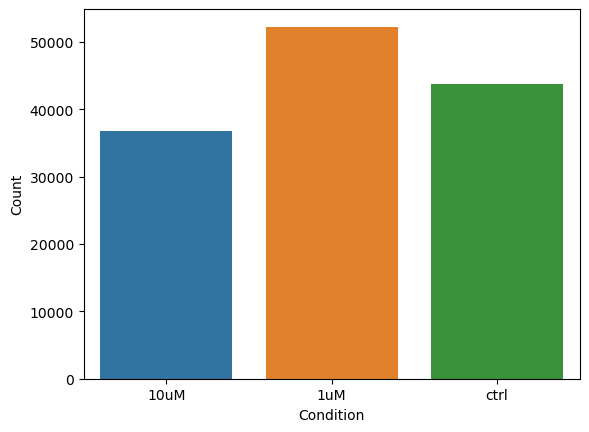

In [45]:
import seaborn as sns 

sns.barplot(data = df_count, x='Condition', y='Count')

<Axes: xlabel='Condition', ylabel='Count per area'>

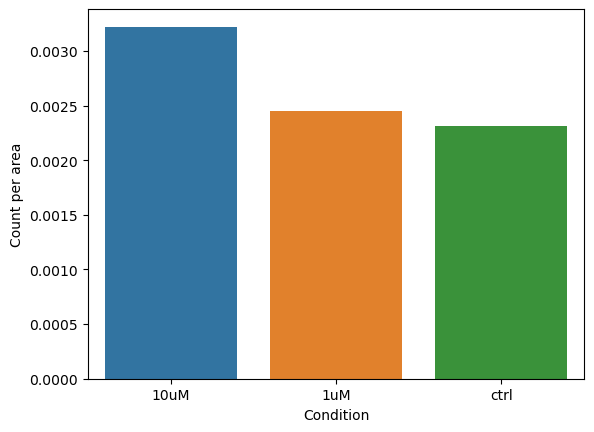

In [48]:
import seaborn as sns 

sns.barplot(data = df_count, x='Condition', y='Count per area')